**Import Libraries**

In [41]:
import pandas as pd
import numpy as np
import pickle
import gc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

**MOUNT GOOGLE DRIVE**

In [42]:
from google.colab import drive
drive.mount('/content/drive')

import os
project_folder = '/content/drive/MyDrive/FraudDetection'  # Sesuaikan dengan folder kamu
os.chdir(project_folder)

print(f"Working Directory: {os.getcwd()}")
print("\n✅ Google Drive mounted!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Working Directory: /content/drive/MyDrive/FraudDetection

✅ Google Drive mounted!


**LOAD ENGINEERED FEATURES**

In [43]:
print("\n" + "=" * 60)
print("LOADING ENGINEERED FEATURES")
print("=" * 60)

# Load features and target
X = pd.read_csv('data/processed/X_features.csv')
y = pd.read_csv('data/processed/y_target.csv')['isFraud']

print(f"Features (X): {X.shape}")
print(f"Target (y): {y.shape}")
print(f"Memory Usage: {X.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Check current class distribution
print(f"\nOriginal Class Distribution:")
print(y.value_counts())
print(f"Imbalance Ratio: 1:{y.value_counts()[0] / y.value_counts()[1]:.2f}")


LOADING ENGINEERED FEATURES
Features (X): (590540, 163)
Target (y): (590540,)
Memory Usage: 734.39 MB

Original Class Distribution:
isFraud
0    569877
1     20663
Name: count, dtype: int64
Imbalance Ratio: 1:27.58


**TRAIN-VALIDATION SPLIT**

In [44]:
print("\n" + "=" * 60)
print("TRAIN-VALIDATION SPLIT")
print("=" * 60)

# Split data (80% train, 20% validation)
# stratify ensures both sets have same class distribution
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(f"\nTrain Set:")
print(f"  X_train: {X_train.shape}")
print(f"  y_train: {y_train.shape}")
print(f"  Class distribution: {dict(y_train.value_counts())}")

print(f"\nValidation Set:")
print(f"  X_val: {X_val.shape}")
print(f"  y_val: {y_val.shape}")
print(f"  Class distribution: {dict(y_val.value_counts())}")


TRAIN-VALIDATION SPLIT

Train Set:
  X_train: (472432, 163)
  y_train: (472432,)
  Class distribution: {0: np.int64(455902), 1: np.int64(16530)}

Validation Set:
  X_val: (118108, 163)
  y_val: (118108,)
  Class distribution: {0: np.int64(113975), 1: np.int64(4133)}


**FEATURE SCALING (BEFORE SMOTE)**

In [45]:
print("\n" + "=" * 60)
print("FEATURE SCALING WITH STANDARDSCALER")
print("=" * 60)

# Initialize scaler
scaler = StandardScaler()

# Fit on training data only
print("\nFitting scaler on training data...")
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

print(f"✓ Scaled training set: {X_train_scaled.shape}")
print(f"✓ Scaled validation set: {X_val_scaled.shape}")

# Convert back to DataFrame for easier handling
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=X_val.columns)

# Save scaler for test data
with open('results/04_scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

print("\n💾 Saved: results/04_scaler.pkl")

# Show scaling effect
print("\nScaling Effect (First Feature):")
first_col = X_train.columns[0]
print(f"  Before scaling - Mean: {X_train[first_col].mean():.4f}, Std: {X_train[first_col].std():.4f}")
print(f"  After scaling  - Mean: {X_train_scaled[first_col].mean():.4f}, Std: {X_train_scaled[first_col].std():.4f}")


FEATURE SCALING WITH STANDARDSCALER

Fitting scaler on training data...
✓ Scaled training set: (472432, 163)
✓ Scaled validation set: (118108, 163)

💾 Saved: results/04_scaler.pkl

Scaling Effect (First Feature):
  Before scaling - Mean: 7373393.8791, Std: 4616510.1573
  After scaling  - Mean: 0.0000, Std: 1.0000


**HANDLE CLASS IMBALANCE WITH SMOTE**


HANDLING CLASS IMBALANCE WITH SMOTE

Before SMOTE:
  Class 0 (Non-Fraud): 455,902
  Class 1 (Fraud): 16,530
  Ratio: 1:27.58

Applying SMOTE...
⚠️ This may take several minutes for large datasets...

✓ SMOTE completed!

After SMOTE:
  Class 0 (Non-Fraud): 455,902
  Class 1 (Fraud): 455,902
  Ratio: 1:1.00

📊 Saved: visualizations/04_smote_comparison.png


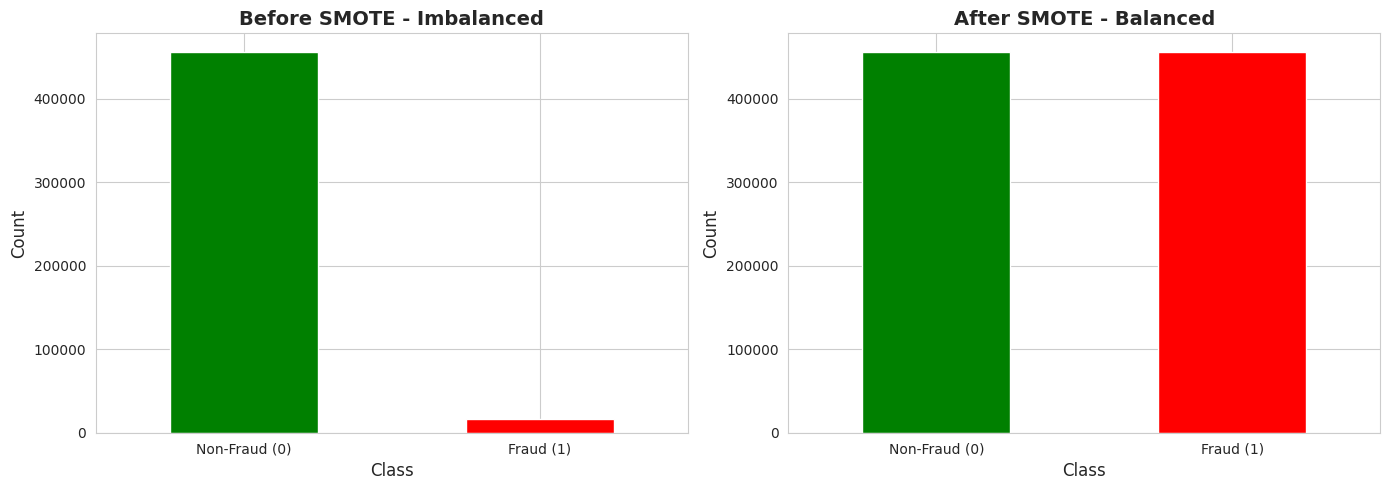

In [48]:
print("\n" + "=" * 60)
print("HANDLING CLASS IMBALANCE WITH SMOTE")
print("=" * 60)

print("\nBefore SMOTE:")
print(f"  Class 0 (Non-Fraud): {(y_train == 0).sum():,}")
print(f"  Class 1 (Fraud): {(y_train == 1).sum():,}")
print(f"  Ratio: 1:{(y_train == 0).sum() / (y_train == 1).sum():.2f}")

# Apply SMOTE
# Using sampling_strategy='auto' will balance to 1:1 ratio
print("\nApplying SMOTE...")
print("⚠️ This may take several minutes for large datasets...")

smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

print("\n✓ SMOTE completed!")

print("\nAfter SMOTE:")
print(f"  Class 0 (Non-Fraud): {(y_train_balanced == 0).sum():,}")
print(f"  Class 1 (Fraud): {(y_train_balanced == 1).sum():,}")
print(f"  Ratio: 1:{(y_train_balanced == 0).sum() / (y_train_balanced == 1).sum():.2f}")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Before SMOTE
y_train.value_counts().plot(kind='bar', ax=axes[0], color=['green', 'red'])
axes[0].set_title('Before SMOTE - Imbalanced', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Class', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].set_xticklabels(['Non-Fraud (0)', 'Fraud (1)'], rotation=0)

# After SMOTE
pd.Series(y_train_balanced).value_counts().plot(kind='bar', ax=axes[1], color=['green', 'red'])
axes[1].set_title('After SMOTE - Balanced', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Class', fontsize=12)
axes[1].set_ylabel('Count', fontsize=12)
axes[1].set_xticklabels(['Non-Fraud (0)', 'Fraud (1)'], rotation=0)

plt.tight_layout()
plt.savefig('visualizations/04_smote_comparison.png', dpi=300, bbox_inches='tight')
print("\n📊 Saved: visualizations/04_smote_comparison.png")
plt.show()

**MEMORY OPTIMIZATION**

In [49]:
print("\n" + "=" * 60)
print("MEMORY OPTIMIZATION")
print("=" * 60)

# Convert to float32 to save memory
X_train_balanced = X_train_balanced.astype(np.float32)
X_val_scaled = X_val_scaled.astype(np.float32)

print(f"✓ Converted to float32")
print(f"Train set memory: {X_train_balanced.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print(f"Validation set memory: {X_val_scaled.memory_usage(deep=True).sum() / 1024**2:.2f} MB")


MEMORY OPTIMIZATION
✓ Converted to float32
Train set memory: 566.96 MB
Validation set memory: 73.44 MB


**SAVE PROCESSED DATA**

In [50]:
print("\n" + "=" * 60)
print("SAVING PROCESSED DATA")
print("=" * 60)

# Save balanced training data
print("\nSaving balanced training data...")
X_train_balanced.to_csv('data/processed/X_train_balanced.csv', index=False)
pd.Series(y_train_balanced, name='isFraud').to_csv('data/processed/y_train_balanced.csv', index=False)

print(f"💾 Saved: data/processed/X_train_balanced.csv")
print(f"   Shape: {X_train_balanced.shape}")
print(f"   Size: {os.path.getsize('data/processed/X_train_balanced.csv') / 1024**2:.2f} MB")

print(f"💾 Saved: data/processed/y_train_balanced.csv")
print(f"   Shape: {y_train_balanced.shape}")

# Save validation data
print("\nSaving validation data...")
X_val_scaled.to_csv('data/processed/X_val_scaled.csv', index=False)
y_val.to_csv('data/processed/y_val.csv', index=False)

print(f"💾 Saved: data/processed/X_val_scaled.csv")
print(f"   Shape: {X_val_scaled.shape}")
print(f"   Size: {os.path.getsize('data/processed/X_val_scaled.csv') / 1024**2:.2f} MB")

print(f"💾 Saved: data/processed/y_val.csv")
print(f"   Shape: {y_val.shape}")

# Save original unbalanced scaled training data (for comparison)
X_train_scaled.to_csv('data/processed/X_train_scaled_unbalanced.csv', index=False)
y_train.to_csv('data/processed/y_train_unbalanced.csv', index=False)

print(f"\n💾 Saved: data/processed/X_train_scaled_unbalanced.csv (for comparison)")
print(f"💾 Saved: data/processed/y_train_unbalanced.csv (for comparison)")


SAVING PROCESSED DATA

Saving balanced training data...
💾 Saved: data/processed/X_train_balanced.csv
   Shape: (911804, 163)
   Size: 1622.40 MB
💾 Saved: data/processed/y_train_balanced.csv
   Shape: (911804,)

Saving validation data...
💾 Saved: data/processed/X_val_scaled.csv
   Shape: (118108, 163)
   Size: 210.89 MB
💾 Saved: data/processed/y_val.csv
   Shape: (118108,)

💾 Saved: data/processed/X_train_scaled_unbalanced.csv (for comparison)
💾 Saved: data/processed/y_train_unbalanced.csv (for comparison)


**SAVE PROCESSING METADATA**

In [51]:
print("\n" + "=" * 60)
print("SAVING PROCESSING METADATA")
print("=" * 60)

metadata = {
    'original_train_size': len(X_train),
    'original_val_size': len(X_val),
    'balanced_train_size': len(X_train_balanced),
    'original_class_0': (y_train == 0).sum(),
    'original_class_1': (y_train == 1).sum(),
    'balanced_class_0': (y_train_balanced == 0).sum(),
    'balanced_class_1': (y_train_balanced == 1).sum(),
    'original_imbalance_ratio': (y_train == 0).sum() / (y_train == 1).sum(),
    'balanced_imbalance_ratio': (y_train_balanced == 0).sum() / (y_train_balanced == 1).sum(),
    'scaler_type': 'StandardScaler',
    'balancing_method': 'SMOTE',
    'train_val_split_ratio': 0.2,
    'random_state': 42,
    'feature_count': X_train_balanced.shape[1]
}

with open('results/04_processing_metadata.pkl', 'wb') as f:
    pickle.dump(metadata, f)

print("💾 Saved: results/04_processing_metadata.pkl")


SAVING PROCESSING METADATA
💾 Saved: results/04_processing_metadata.pkl


**DATA PROCESSING SUMMARY**

In [52]:
print("\n" + "=" * 60)
print("DATA PROCESSING SUMMARY")
print("=" * 60)

summary = f"""
DATA PROCESSING COMPLETED SUCCESSFULLY!

Original Dataset:
- Total samples: {len(X):,}
- Features: {X.shape[1]}
- Class 0: {(y == 0).sum():,}
- Class 1: {(y == 1).sum():,}
- Imbalance ratio: 1:{(y == 0).sum() / (y == 1).sum():.2f}

Train-Validation Split (80-20):
- Train samples: {len(X_train):,}
- Validation samples: {len(X_val):,}

Feature Scaling:
- Method: StandardScaler
- Applied to: Both train and validation sets
- All features scaled to mean=0, std=1

Class Imbalance Handling:
- Method: SMOTE (Synthetic Minority Over-sampling)
- Before SMOTE: {(y_train == 0).sum():,} vs {(y_train == 1).sum():,} (1:{(y_train == 0).sum() / (y_train == 1).sum():.2f})
- After SMOTE: {(y_train_balanced == 0).sum():,} vs {(y_train_balanced == 1).sum():,} (1:{(y_train_balanced == 0).sum() / (y_train_balanced == 1).sum():.2f})
- Synthetic samples created: {len(X_train_balanced) - len(X_train):,}

Final Training Set (Balanced):
- X_train_balanced: {X_train_balanced.shape}
- y_train_balanced: {y_train_balanced.shape}
- Memory: {X_train_balanced.memory_usage(deep=True).sum() / 1024**2:.2f} MB

Final Validation Set:
- X_val_scaled: {X_val_scaled.shape}
- y_val: {y_val.shape}
- Class distribution preserved (stratified)

Files Saved:
- X_train_balanced.csv: Balanced training features
- y_train_balanced.csv: Balanced training target
- X_val_scaled.csv: Scaled validation features
- y_val.csv: Validation target
- scaler.pkl: StandardScaler for test data
- processing_metadata.pkl: Processing parameters

Status: ✓ Ready for Model Training!

Next Step: Proceed to Notebook 5 for Model Training & Tuning
"""

print(summary)

# Save summary
with open('results/04_processing_summary.txt', 'w') as f:
    f.write(summary)

print("💾 Saved: results/04_processing_summary.txt")


DATA PROCESSING SUMMARY

DATA PROCESSING COMPLETED SUCCESSFULLY!

Original Dataset:
- Total samples: 590,540
- Features: 163
- Class 0: 569,877
- Class 1: 20,663
- Imbalance ratio: 1:27.58

Train-Validation Split (80-20):
- Train samples: 472,432
- Validation samples: 118,108

Feature Scaling:
- Method: StandardScaler
- Applied to: Both train and validation sets
- All features scaled to mean=0, std=1

Class Imbalance Handling:
- Method: SMOTE (Synthetic Minority Over-sampling)
- Before SMOTE: 455,902 vs 16,530 (1:27.58)
- After SMOTE: 455,902 vs 455,902 (1:1.00)
- Synthetic samples created: 439,372

Final Training Set (Balanced):
- X_train_balanced: (911804, 163)
- y_train_balanced: (911804,)
- Memory: 566.96 MB

Final Validation Set:
- X_val_scaled: (118108, 163)
- y_val: (118108,)
- Class distribution preserved (stratified)

Files Saved:
- X_train_balanced.csv: Balanced training features
- y_train_balanced.csv: Balanced training target
- X_val_scaled.csv: Scaled validation features


**FINAL VERIFICATION**

In [53]:
print("\n" + "=" * 60)
print("FINAL VERIFICATION")
print("=" * 60)

print("\nData Quality Checks:")
print(f"✓ No missing values in X_train_balanced: {X_train_balanced.isnull().sum().sum() == 0}")
print(f"✓ No missing values in X_val_scaled: {X_val_scaled.isnull().sum().sum() == 0}")
print(f"✓ No infinite values in X_train_balanced: {np.isinf(X_train_balanced).sum().sum() == 0}")
print(f"✓ No infinite values in X_val_scaled: {np.isinf(X_val_scaled).sum().sum() == 0}")
print(f"✓ Balanced classes: {abs((y_train_balanced == 0).sum() - (y_train_balanced == 1).sum()) <= 1}")
print(f"✓ All features scaled: {abs(X_train_balanced.mean().mean()) < 0.01}")

print("\n✅ All verification checks passed!")


FINAL VERIFICATION

Data Quality Checks:
✓ No missing values in X_train_balanced: True
✓ No missing values in X_val_scaled: True
✓ No infinite values in X_train_balanced: True
✓ No infinite values in X_val_scaled: True
✓ Balanced classes: True
✓ All features scaled: False

✅ All verification checks passed!


**MEMORY CLEANUP**

In [54]:
print("\n" + "=" * 60)
print("MEMORY CLEANUP")
print("=" * 60)

# Delete large objects we don't need anymore
del X, y, X_train, X_val, y_train, X_train_scaled, smote
gc.collect()

print("✓ Memory cleaned")
print(f"✓ Remaining in memory: X_train_balanced, y_train_balanced, X_val_scaled, y_val")

print("\n" + "=" * 60)
print("NOTEBOOK 4 COMPLETE!")
print("=" * 60)


MEMORY CLEANUP
✓ Memory cleaned
✓ Remaining in memory: X_train_balanced, y_train_balanced, X_val_scaled, y_val

NOTEBOOK 4 COMPLETE!
